In [1]:
# Load Packages

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import os
import itertools
import copy
import datetime, time
import sklearn
import random
import scipy
import statsmodels.api as sm
import pylab as pl

from pandas import Series, DataFrame
from scipy.stats import spearmanr
from pylab import rcParams
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from numpy import array 

In [2]:
#Import Dataset

filename = '/Users/Geoff/Desktop/MMAI/CAPSTONE/aragon-all-votes_outcome feature_excelv4.csv'
df = pd.read_csv(filename)

In [3]:
#Prepare data

df['vote'] = df['vote'].eq('Yes').astype(int)
df['Result'] = df['Result'].eq('Yes').astype(int)
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
df['timestamp'] = df['timestamp'].values.astype(np.float)

In [4]:
#Normalise data across votes

#group by vote 
df_vote  = df.groupby('voting_number')
print(type(df_vote))

#normalise timestamps and stake amount across groups
df['timestamp_norm'] = df.groupby('voting_number')['timestamp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
df['staked_norm'] = df.groupby('voting_number')['staked_ANT_amount'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

<class 'pandas.core.groupby.groupby.DataFrameGroupBy'>


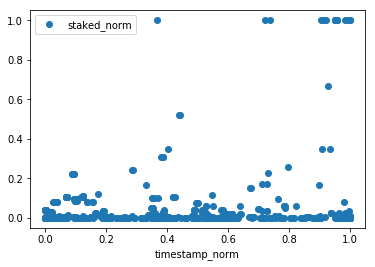

In [5]:
#Plot Data
df.plot(x='timestamp_norm', y='staked_norm', style='o')

In [6]:
# df['norm_vote'] = np.multiply(df['Vote Weight'], df['staked_norm'])

In [7]:
df.head()

,voting_number,timestamp,voter,vote,staked_ANT_amount,tx,Vote Weight,Result,cluster,timestamp_norm,staked_norm
0,0,1.548288e+18,0x17d38262ceb5317af645a246b0ce6fc4cc3088f6,1,249.980000,0x7bffb2e0cf5e1a73bea38565d25821418344269bd144...,1,1,3,0.000000,0.000131
1,0,1.548293e+18,0x2b5afa7a939e475a327c763f725d88e8a92ce342,1,1510.761544,0x51947df002e5ac8bb2928e083dfd5d57b9e2ac0bee26...,1,1,3,0.028919,0.000790
2,0,1.548298e+18,0x839395e20bbb182fa440d08f850e6c7a8f6f0780,1,2987.342012,0x3b62bc58824723f7507f4dfd33b7a9e3ff941a6f7cad...,1,1,3,0.059519,0.001561
3,0,1.548299e+18,0xd472fa32294977196b9ad47e7865e0d737220e32,1,5602.726497,0xac26a765b069f9db78c532e07889599e2c855ec9c36b...,1,1,3,0.069232,0.002929
4,0,1.548299e+18,0xd472fa32294977196b9ad47e7865e0d737220e32,1,5602.726497,0x7a620bf8e4f80c0646e2cec6bd9cba108a29e8c17c68...,1,1,3,0.069483,0.002929


In [8]:
df.tail()

,voting_number,timestamp,voter,vote,staked_ANT_amount,tx,Vote Weight,Result,cluster,timestamp_norm,staked_norm
634,15,1.556303e+18,0xbfc7cae0fad9b346270ae8fde24827d2d779ef07,0,218.40815,0xb57db8c2008420bc67eb2908c2a9caef201e8abcba5d...,-1,1,1,0.564496,0.000276
635,15,1.556312e+18,0x662127bf82b794a26b7ddb6b495f6a5a20b81738,1,1.00000,0x25a15b7d06e559a93d6719f3399b0b5927c54774862b...,1,1,1,0.619211,0.000001
636,15,1.556369e+18,0x8b6a9b7c8d8ed99ff02314f779f5a1b7e8474548,1,20000.00000,0x6cbfacf247cc2b1ac87e791d78de6ed05790b2681023...,1,1,2,0.963708,0.025246
637,15,1.556373e+18,0xd8265cc1d176a0d734834a0f60d9d2d53bae66f6,1,792191.00000,0x7f92999ef067bb194d92699c6faf3c0111d9791bafdd...,1,1,0,0.984339,1.000000
638,15,1.556375e+18,0x1dffdb114e58baedbd25290a1efffa9fc3726d1f,1,3000.00000,0x6181d270f8d2d022fd5d7bee74ead729255d568e21a3...,1,1,2,1.000000,0.003787


In [9]:
#LOGITICS REGRESSION WITHOUT CLUSTERS

#dropping unecessary columns 
df1 = df.drop(['voting_number'], axis = 1)
df1 = df1.drop(['timestamp'], axis = 1)
df1 = df1.drop(['voter'], axis = 1)
df1 = df1.drop(['staked_ANT_amount'], axis = 1)
df1 = df1.drop(['tx'], axis = 1)
df1 = df1.drop(['Vote Weight'], axis = 1)
df1 = df1.drop(['vote'], axis = 1)
# df1 = df1.drop(['staked_norm'], axis = 1)
df1 = df1.drop(['cluster'], axis = 1)


In [10]:
#splitting into features and target variable
X = df1.drop('Result',axis=1)
y = df1['Result']

In [11]:
df1.head()

,Result,timestamp_norm,staked_norm
0,1,0.000000,0.000131
1,1,0.028919,0.000790
2,1,0.059519,0.001561
3,1,0.069232,0.002929
4,1,0.069483,0.002929


In [12]:
#splitting data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)

In [13]:
#Adapted from code from Neal Gilmore from MMAI Assignment
print("No. of votes in the X_train dataset: ", X_train.shape)
print("No. of votes in the y_train dataset: ", y_train.shape)
print("No. of votes in the X_test dataset: ", X_test.shape)
print("No. of votes in the y_test dataset: ", y_test.shape)
print("\nCounts of label '1' before oversampling: {}".format(sum(y_train == 1)))
print("Counts of label '0' before oversampling: {} \n".format(sum(y_train == 0)))

No. of votes in the X_train dataset:  (511, 2)
No. of votes in the y_train dataset:  (511,)
No. of votes in the X_test dataset:  (128, 2)
No. of votes in the y_test dataset:  (128,)

Counts of label '1' before oversampling: 378
Counts of label '0' before oversampling: 133 



In [14]:
#Applying SMOTE to oversample data
sm = SMOTE(random_state=88, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [15]:
#Adapted from code from Neal Gilmore from MMAI Assignment
print('Shape of X_train after oversampling: {}'.format(X_train_res.shape))
print('Shape of y_train after oversampling: {} \n'.format(y_train_res.shape))
print("Counts of label '1' after oversampling: {}".format(sum(y_train_res == 1)))
print("Counts of label '0' after oversampling: {}".format(sum(y_train_res == 0)))

Shape of X_train after oversampling: (756, 2)
Shape of y_train after oversampling: (756,) 

Counts of label '1' after oversampling: 378
Counts of label '0' after oversampling: 378


In [16]:
#instantiating Logistic Regression Model
reg_all = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
#training the model
reg_all.fit(X_train_res,y_train_res)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
#running model on testing set
y_pred = reg_all.predict(X_test)

In [19]:
#accuracy
reg_all.score(X_test,y_test)

0.59375

In [20]:
#printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[19 11]
 [41 57]]


In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.63      0.42        30
           1       0.84      0.58      0.69        98

   micro avg       0.59      0.59      0.59       128
   macro avg       0.58      0.61      0.55       128
weighted avg       0.72      0.59      0.62       128



In [22]:
reg_all.coef_

array([[0.37891396, 0.28598567]])

In [23]:
#Showing the AUC. Code adapted from Team Greenwood Code submited for a Group Assignment
y_pred_prob = reg_all.predict_proba(X_test)[:,1]

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

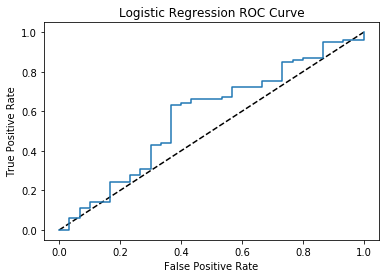

In [25]:
plt.plot([0,1],[0,1],'k--')

plt.plot(fpr,tpr, label ='Logistic Regression')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC Curve')

plt.show();

In [26]:
roc_auc_score(y_test, y_pred_prob)

0.5758503401360544

In [27]:
#cross validation
cv_scores = cross_val_score(reg_all, X_test, y_test, cv=5,scoring='roc_auc')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [28]:
print(cv_scores)

[0.50833333 0.84166667 0.46666667 0.64035088 0.31578947]


In [29]:
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",cv_scores.mean() * 100)

Accuracy of Model with Cross Validation is: 55.456140350877206


In [33]:
##LOGISTIC REGRESSION WITH CLUSTERS
#dropping unecessary columns 
df2 = df.drop(['voting_number'], axis = 1)
df2 = df2.drop(['timestamp'], axis = 1)
df2 = df2.drop(['vote'], axis = 1)
df2 = df2.drop(['staked_ANT_amount'], axis = 1)
df2 = df2.drop(['tx'], axis = 1)
df2 = df2.drop(['Vote Weight'], axis = 1)
df2 = df2.drop(['voter'], axis = 1)
# df2 = df2.drop(['staked_norm'], axis = 1)

In [34]:
#Label encode voters
#df.apply(preprocessing.LabelEncoder().fit_transform(df['voter']))

In [35]:
df2.head()

,Result,cluster,timestamp_norm,staked_norm
0,1,3,0.000000,0.000131
1,1,3,0.028919,0.000790
2,1,3,0.059519,0.001561
3,1,3,0.069232,0.002929
4,1,3,0.069483,0.002929


In [36]:
#splitting into features and target variable
X2 = df2.drop('Result',axis=1)
y2 = df2['Result']

In [37]:
#splitting data into testing and training sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 88)

In [38]:
print("No. of votes in the X_train dataset: ", X2_train.shape)
print("No. of votes in the y_train dataset: ", y2_train.shape)
print("No. of votes in the X_test dataset: ", X2_test.shape)
print("No. of votes in the y_test dataset: ", y2_test.shape)
print("\nCounts of label '1' before oversampling: {}".format(sum(y_train == 1)))
print("Counts of label '0' before oversampling: {} \n".format(sum(y_train == 0)))

No. of votes in the X_train dataset:  (511, 3)
No. of votes in the y_train dataset:  (511,)
No. of votes in the X_test dataset:  (128, 3)
No. of votes in the y_test dataset:  (128,)

Counts of label '1' before oversampling: 378
Counts of label '0' before oversampling: 133 



In [39]:
#Applying SMOTE to oversample data
sm = SMOTE(random_state=88, ratio = 1.0)
X2_train_res, y2_train_res = sm.fit_sample(X2_train, y2_train.ravel())

In [40]:
print('Shape of X_train after oversampling: {}'.format(X2_train_res.shape))
print('Shape of y_train after oversampling: {} \n'.format(y2_train_res.shape))
print("Counts of label '1' after oversampling: {}".format(sum(y2_train_res == 1)))
print("Counts of label '0' after oversampling: {}".format(sum(y2_train_res == 0)))

Shape of X_train after oversampling: (756, 3)
Shape of y_train after oversampling: (756,) 

Counts of label '1' after oversampling: 378
Counts of label '0' after oversampling: 378


In [41]:
#instantiating Logistic Regression Model
reg2_all = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
#training the model
reg2_all.fit(X2_train_res,y2_train_res)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
#running model on testing set
y2_pred = reg2_all.predict(X2_test)

In [44]:
#accuracy
reg2_all.score(X2_test,y2_test)

0.6328125

In [45]:
#printing confusion matrix
print(confusion_matrix(y2_test,y2_pred))

[[18 12]
 [35 63]]


In [46]:
print(classification_report(y2_test,y2_pred))

              precision    recall  f1-score   support

           0       0.34      0.60      0.43        30
           1       0.84      0.64      0.73        98

   micro avg       0.63      0.63      0.63       128
   macro avg       0.59      0.62      0.58       128
weighted avg       0.72      0.63      0.66       128



In [47]:
reg2_all.coef_

array([[-0.07269748,  0.25132849,  0.24494866]])

In [48]:
#Showing the AUC 
y2_pred_prob = reg2_all.predict_proba(X2_test)[:,1]

In [49]:
fpr2, tpr2, thresholds = roc_curve(y2_test, y2_pred_prob)

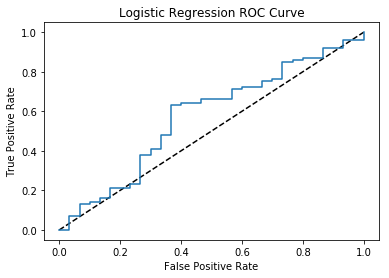

In [50]:
plt.plot([0,1],[0,1],'k--')

plt.plot(fpr2,tpr2, label ='Logistic Regression')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC Curve')

plt.show();

In [51]:
roc_auc_score(y2_test, y2_pred_prob)

0.5741496598639456

In [52]:
#cross validation
cv2_scores = cross_val_score(reg2_all, X2_test, y2_test, cv=5,scoring='roc_auc')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [53]:
print(cv2_scores)

[0.58333333 0.71666667 0.48333333 0.71929825 0.28070175]


In [54]:
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",cv2_scores.mean() * 100)

Accuracy of Model with Cross Validation is: 55.666666666666664


In [57]:
###Log Regression with voter preference (Yes/NO)

df3 = df.drop(['voting_number'], axis = 1)
df3 = df3.drop(['timestamp'], axis = 1)
df3 = df3.drop(['staked_ANT_amount'], axis = 1)
df3 = df3.drop(['tx'], axis = 1)
df3 = df3.drop(['Vote Weight'], axis = 1)
df3 = df3.drop(['voter'], axis = 1)
# df3 = df3.drop(['staked_norm'], axis = 1)

In [58]:
df3.head()

,vote,Result,cluster,timestamp_norm,staked_norm
0,1,1,3,0.000000,0.000131
1,1,1,3,0.028919,0.000790
2,1,1,3,0.059519,0.001561
3,1,1,3,0.069232,0.002929
4,1,1,3,0.069483,0.002929


In [59]:
#splitting into features and target variable
X3 = df3.drop('Result',axis=1)
y3 = df3['Result']

In [60]:
#splitting data into testing and training sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 88)

In [61]:
print("No. of votes in the X_train dataset: ", X3_train.shape)
print("No. of votes in the y_train dataset: ", y3_train.shape)
print("No. of votes in the X_test dataset: ", X3_test.shape)
print("No. of votes in the y_test dataset: ", y3_test.shape)
print("\nCounts of label '1' before oversampling: {}".format(sum(y_train == 1)))
print("Counts of label '0' before oversampling: {} \n".format(sum(y_train == 0)))

No. of votes in the X_train dataset:  (511, 4)
No. of votes in the y_train dataset:  (511,)
No. of votes in the X_test dataset:  (128, 4)
No. of votes in the y_test dataset:  (128,)

Counts of label '1' before oversampling: 378
Counts of label '0' before oversampling: 133 



In [62]:
#Applying SMOTE to oversample data
sm3 = SMOTE(random_state=88, ratio = 1.0)
X3_train_res, y3_train_res = sm.fit_sample(X3_train, y3_train.ravel())

In [63]:
print('Shape of X_train after oversampling: {}'.format(X3_train_res.shape))
print('Shape of y_train after oversampling: {} \n'.format(y3_train_res.shape))
print("Counts of label '1' after oversampling: {}".format(sum(y3_train_res == 1)))
print("Counts of label '0' after oversampling: {}".format(sum(y3_train_res == 0)))

Shape of X_train after oversampling: (756, 4)
Shape of y_train after oversampling: (756,) 

Counts of label '1' after oversampling: 378
Counts of label '0' after oversampling: 378


In [64]:
#instantiating Logistic Regression Model
reg3_all = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
#training the model
reg3_all.fit(X3_train_res,y3_train_res)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [66]:
#running model on testing set
y3_pred = reg3_all.predict(X3_test)

In [67]:
#accuracy
reg3_all.score(X3_test,y3_test)

0.8046875

In [68]:
#printing confusion matrix
print(confusion_matrix(y3_test,y3_pred))

[[19 11]
 [14 84]]


In [69]:
print(classification_report(y3_test,y3_pred))

              precision    recall  f1-score   support

           0       0.58      0.63      0.60        30
           1       0.88      0.86      0.87        98

   micro avg       0.80      0.80      0.80       128
   macro avg       0.73      0.75      0.74       128
weighted avg       0.81      0.80      0.81       128



In [70]:
reg3_all.coef_

array([[ 1.50784329, -0.15893665,  0.1481658 ,  0.44416883]])

In [71]:
#Showing the AUC 
y3_pred_prob = reg3_all.predict_proba(X3_test)[:,1]

In [72]:
fpr3, tpr3, thresholds = roc_curve(y3_test, y3_pred_prob)

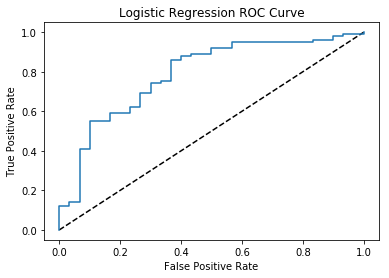

In [73]:
plt.plot([0,1],[0,1],'k--')

plt.plot(fpr3,tpr3, label ='Logistic Regression')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC Curve')

plt.show();

In [74]:
roc_auc_score(y3_test, y3_pred_prob)

0.7863945578231292

In [75]:
#cross validation
cv3_scores = cross_val_score(reg3_all, X3_test, y3_test, cv=5,scoring='roc_auc')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [76]:
print(cv3_scores)

[0.95833333 0.80833333 0.76666667 0.78947368 0.64035088]


In [77]:
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",cv3_scores.mean() * 100)

Accuracy of Model with Cross Validation is: 79.26315789473685
